In [1]:
!pip install roboflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.3 MB/s eta 0:00:00


In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="8Z4ck3hgIdLkrbFet3Yj")
project = rf.workspace("yolo-zbpxw").project("fruit-classification-iszdx")
version = project.version(2)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fruit-classification-2 in folder:: 100%|██████████| 125/125 [00:00<00:00, 5550.78it/s]


## 視覺化資料集

In [3]:
import os
import matplotlib.pyplot as plt
import cv2

def load_images_from_folder(folder, title):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))[:, :, ::-1]
        if img is not None:
            images.append(img)
        if len(images)>3:
            break
    fig=plt.figure(figsize=(15,15))
    xrange=range(1,5)
    for img,x in zip(images,xrange):
        ax=fig.add_subplot(1,4,x)
        ax.imshow(img)
        ax.set_title(title)
        plt.axis('off')

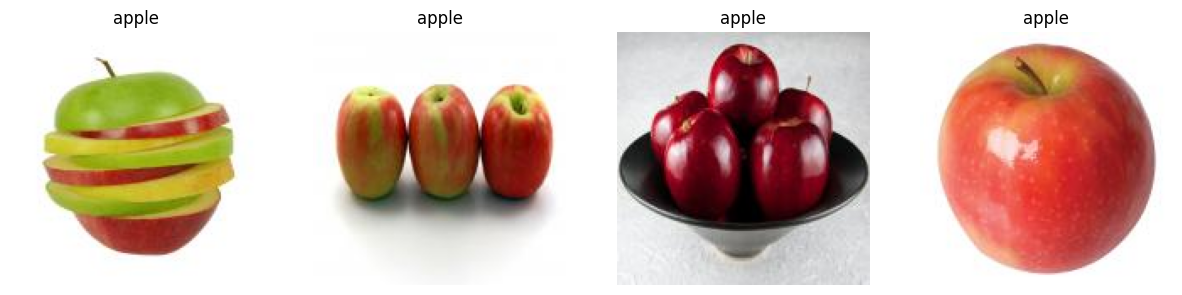

In [4]:
load_images_from_folder("/content/fruit-classification-2/train/apple", title='apple')

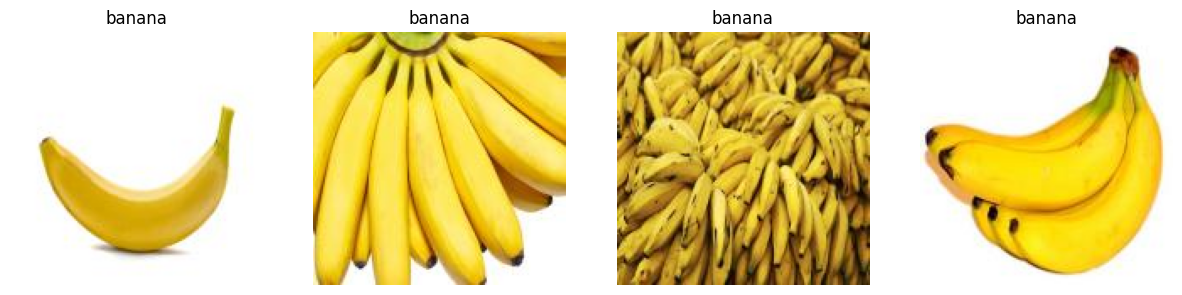

In [5]:
load_images_from_folder("/content/fruit-classification-2/train/banana", title='banana')

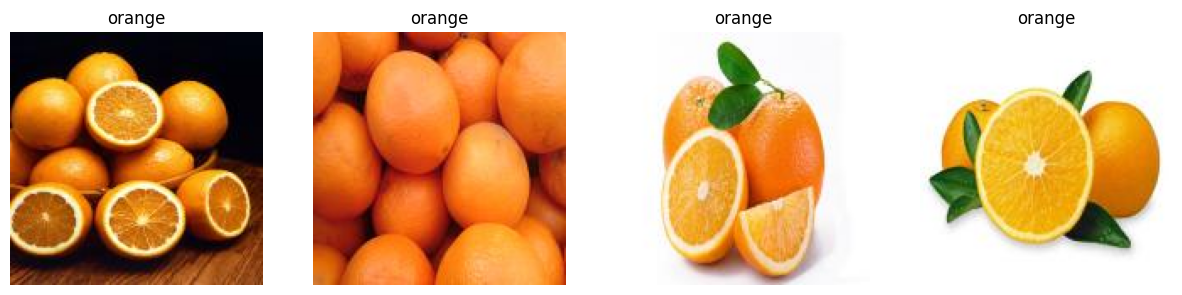

In [6]:
load_images_from_folder("/content/fruit-classification-2/train/orange", title='orange')

## 載入預訓練模型

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam

In [13]:
img_size = 150
model_name = 'ResNet50'

# 使用預訓練的ResNet50模型
pre_model = ResNet50(weights='imagenet', include_top=False,
                   input_shape=(img_size, img_size, 3))

# 將預訓練模型的權重設為不可訓練
pre_model.trainable = False
# 隱藏層
x = layers.GlobalAveragePooling2D()(pre_model.output)
# 輸出層
outputs = layers.Dense(3, activation='softmax')(x)
model = Model(inputs=pre_model.inputs, outputs=outputs)
# 設定優化器
optimizer = Adam(learning_rate=0.001)
# 編譯模型
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

## 載入圖片

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 建立訓練資料生成器
train_datagen = ImageDataGenerator(
               width_shift_range=0.1,  # 隨機水平位移圖像的範圍
               height_shift_range=0.1,  # 隨機垂直位移圖像的範圍
               horizontal_flip=True,  # 隨機水平翻轉圖像
               preprocessing_function=preprocess_input,  # 圖像前處理函數
               validation_split=0.01  # 驗證資料集的比例
              )

# 建立驗證資料生成器
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.3)

In [15]:
# 設定圖像的尺寸
img_shape = (img_size, img_size)

# 創建訓練資料生成器，從指定資料夾中讀取圖像，並進行資料增強
train_generator = train_datagen.flow_from_directory(
                 '/content/fruit-classification-2/train',
                 target_size=(img_size, img_size),  # 調整圖像尺寸
                 batch_size=16,  # 批次大小
                 shuffle=True,  # 隨機打亂圖像順序
                 class_mode='categorical',  # 分類
                 subset='training')  # 設定為訓練子集

# 創建驗證資料生成器，從指定資料夾中讀取圖像
validation_generator =  validation_datagen.flow_from_directory(
                        '/content/fruit-classification-2/train',
                        target_size=(img_size, img_size),  # 調整圖像尺寸
                        batch_size=16,  # 批次大小
                        class_mode='categorical',  # 分類
                        subset='validation')  # 設定為驗證子集

Found 104 images belonging to 3 classes.
Found 31 images belonging to 3 classes.


In [16]:
# 訓練模型
model.fit(train_generator,
          epochs=3,
          validation_data=validation_generator)

Epoch 1/3
7/7 [==============================] - 8s 559ms/step - loss: 0.7989 - accuracy: 0.6635 - val_loss: 0.1844 - val_accuracy: 0.9677
Epoch 2/3
7/7 [==============================] - 1s 103ms/step - loss: 0.1523 - accuracy: 0.9712 - val_loss: 0.0642 - val_accuracy: 1.0000
Epoch 3/3
7/7 [==============================] - 1s 107ms/step - loss: 0.0565 - accuracy: 1.0000 - val_loss: 0.0260 - val_accuracy: 1.0000


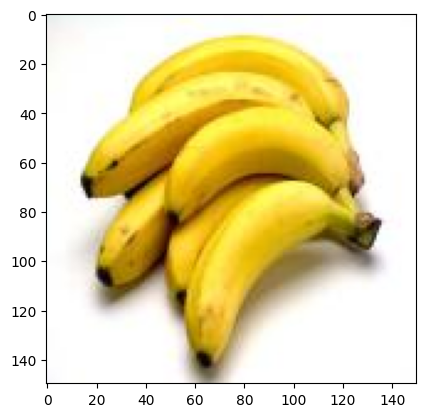

In [45]:
import numpy as np

# 載入圖像
image = tf.keras.utils.load_img('/content/fruit-classification-2/test/apple/41_jpg.rf.127bb6d34dfefbcb8eb4f7a988e60338.jpg', target_size=(img_size, img_size))
image = tf.keras.utils.img_to_array(image) # 將載入的圖像轉換為數組形式

plt.imshow(image.astype(np.uint8))

In [46]:
x = np.expand_dims(image.copy(), axis=0) # 將圖像轉換為模型可接受的維度
# # 預處理圖像
x_preprocess = preprocess_input(x.copy())
# 進行圖像分類預測
pred_proba = model.predict(x_preprocess) # 返回分類機率
pred_proba

1/1 [==============================] - 0s 22ms/step


array([[1.4606418e-04, 9.9977428e-01, 7.9560094e-05]], dtype=float32)

## XAI解釋模型

In [30]:
!pip install shap -q

  0%|          | 0/198 [00:00<?, ?it/s]

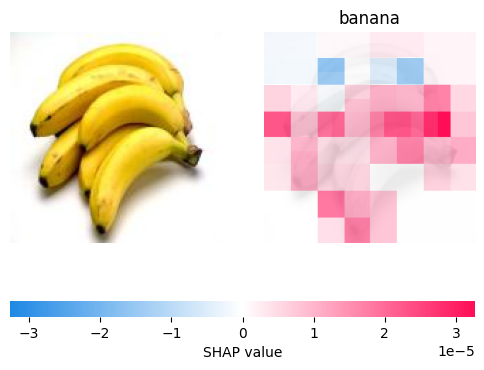

In [47]:
import shap

# 包裝要被解釋的模型
def f(X):
    tmp = X.copy()
    preprocess_input(tmp) # 影像前處理
    return model(tmp)

# 定義一個 masker 用於遮罩圖像的部分區域
masker = shap.maskers.Image("blur(10, 10)", x[0].shape)
# 使用 Partition explainer 解釋模型
explainer = shap.Explainer(f, masker, output_names=["apple", 'banana', 'orange'])
# 估計 Shapely values
shap_values = explainer(x, max_evals=200, batch_size=1, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values, x.astype(np.uint8))